In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [ ]:
dataset = datasets.MNIST('mnist', train=True, download=True, transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
class View(nn.Module):
    def __init__(self, shape):
        self.shape = shape
    def forward(self, x):
        return x.view(*shape)

In [ ]:
latent_dim = 256 
input_size = 784

class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=256, z_dim=32):
        super().__init__()
        
        self.encoder = nn.Sequential(
              nn.Linear(input_size, 512),
              nn.LeakyReLU(0.2, inplace=True),
              nn.Linear(512, latent_dim),
        )
        
        self.h2mu = nn.Linear(h_dim, z_dim)
        self.h2sigma = nn.Linear(h_dim, z_dim)
        self.z2h = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            nn.LeakyReLU(),
            nn.Linear(latent_dim,512),
            nn.LeakyReLU(inplace=True),
            nn.Linear(512,input_size),
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, logvar):
        # если не понимаете, как это работает, спросите
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size())
        z = mu + std * eps
        return z
    
    def bottleneck(self, h):
        mu = self.h2mu(h)
        logvar = self.h2sigma(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def encode(self, x):
        # это можно использовать для морфинга, например
        return self.bottleneck(self.encoder(x))[0]

    def decode(self, z):
        return self.decoder(self.z2h(z))
    
    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.z2h(z)
        return self.decoder(z), mu, logvar

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.view(-1, input_size), x.view(-1, input_size), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD
    
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
for epoch in range(10):
    train_loss = 0
    for data, _ in tqdm.tqdm(loader):
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        
        train_loss += loss.item()
        
        optimizer.step()
        
    print('epoch %d, loss %.4f' % (epoch, train_loss / len(dataset)))

  0%|          | 4/938 [00:00<00:25, 36.18it/s]

epoch 0, loss 149.6099


  0%|          | 4/938 [00:00<00:24, 38.82it/s]

epoch 1, loss 115.5059


  0%|          | 4/938 [00:00<00:25, 36.39it/s]

epoch 2, loss 110.1077


  0%|          | 4/938 [00:00<00:24, 37.96it/s]

epoch 3, loss 107.5831


  0%|          | 4/938 [00:00<00:23, 39.34it/s]

epoch 4, loss 105.9369


  0%|          | 4/938 [00:00<00:25, 37.01it/s]

epoch 5, loss 104.8418


  0%|          | 4/938 [00:00<00:23, 39.92it/s]

epoch 6, loss 103.9662


  0%|          | 4/938 [00:00<00:25, 36.81it/s]

epoch 7, loss 103.3032


  0%|          | 4/938 [00:00<00:24, 37.43it/s]

epoch 8, loss 102.7294


100%|██████████| 938/938 [00:24<00:00, 38.96it/s]

epoch 9, loss 102.3089


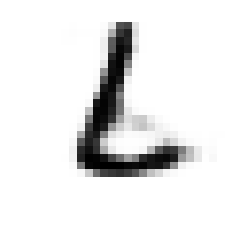

In [ ]:
def get(x):
    return dataset[x][0].view(1, 784)  

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay):
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in np.linspace(0, 1, steps):
            c = a*(1-t)+b*t
            morphed = model.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))
    
morph(np.random.randint(0, len(dataset), 30), 20, 30)

In [ ]:
from google.colab import drive
drive.mount('dr')

Mounted at dr


In [ ]:
!unzip /content/dr/MyDrive/tinkoff/data_em.zip

Archive:  /content/dr/MyDrive/tinkoff/data_em.zip
  inflating: data_em                 


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
DATA_FILE = "data_em"
w = 73

In [ ]:
X = np.load(DATA_FILE)

In [ ]:
H, W, N = X.shape
H,W,N

(100, 200, 1000)

(-0.5, 199.5, 99.5, -0.5)

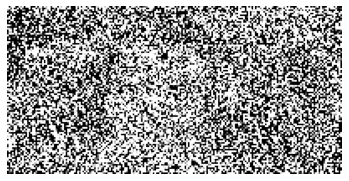

In [ ]:
plt.imshow(X[:, :, 0], cmap="Greys_r")
plt.axis("off")

In [ ]:
tH, tW, tw, tK = 2, 3, 1, 2
tX = np.arange(tH*tW*tK).reshape(tH, tW, tK)
tF = np.arange(tH*tw).reshape(tH, tw)
tB = np.arange(tH*tW).reshape(tH, tW)
ts = 0.1
ta = np.arange(1, (tW-tw+1)+1)
ta = ta / ta.sum()
tq = np.arange(1, (tW-tw+1)*tK+1).reshape(tW-tw+1, tK)
tq = tq / tq.sum(axis=0)[np.newaxis, :]

In [ ]:
def step_calc_log_prob(H,W,K,w,lis,reduce_b,compound,idx):
    comb = np.zeros((H, W))
    comb[:, idx:idx + w] = F
    reduce_f = X[:, :, index] - comb[:, :]
    multiply_2 = np.multiply(reduce_f, reduce_f)
    patternxb = np.ones((H, W))
    patternxb[:, idx:idx + w] = 0
    XF_mask = 1 - patternxb
    XB_temp = np.multiply(compound, patternxb)
    XF_temp = np.multiply(multiply_2, XF_mask)
    total = (np.sum(XB_temp + XF_temp)) * (-1 / (2 * s ** 2)) - H * W * np.log(np.sqrt(2 * np.pi) * s)
    lis[idx][index] = total
    return lis

In [ ]:
def calculate_log_probability(X, F, B, s):
    H,W,K = X.shape
    w = F.shape[1]
    ll = np.zeros((W-w+1,K))
    for k in range(K):
        X_minus_B = X[:,:,k]-B[:,:]
        XB = np.multiply(X_minus_B,X_minus_B)
        for dk in range(W-w+1):
            F_temp = np.zeros((H,W))
            F_temp[:,dk:dk+w] = F
            X_minus_F = X[:,:,k] - F_temp[:,:]
            XF = np.multiply(X_minus_F,X_minus_F)
            XB_mask = np.ones((H,W))
            XB_mask[:,dk:dk+w] = 0
            XF_mask = 1-XB_mask
            XB_temp = np.multiply(XB,XB_mask)
            XF_temp = np.multiply(XF,XF_mask)   
            Sum = (np.sum(XB_temp+XF_temp))*(-1/(2*s**2))-H*W*np.log(np.sqrt(2*np.pi)*s)
            ll[dk][k]=Sum    
    return ll

In [ ]:
def calculate_lower_bound(X, F, B, s, A, q):
    _,_,K = X.shape
    lis = calculate_log_probability(X, F, B, s)
    multiply = np.multiply(lis, q)
    multiply_2 = np.multiply(np.log(q), q)
    waiting = 0
    for k in range(K):
        waiting += np.multiply(np.log(A), q[:, k])
    lower_bound = np.sum(multiply) - np.sum(multiply_2) + np.sum(waiting)
    return lower_bound

In [ ]:
def run_e_step(X, F, B, s, a):
    prob = calculate_log_probability(X,F,B,s)
    _,_,K = X.shape
    for k in range(K):
        maximum = prob[:,k].max()
        prob[:,k] -= maximum
        prob[:,k] = np.exp(prob[:,k])*a
        common_ratio = np.sum(prob[:,k])
        prob[:,k] /= common_ratio
    return prob

In [ ]:
def run_m_step(X, q, w):
    H,W,K = X.shape
    a = np.sum(q, axis=1) / np.sum(q)
    F = np.zeros((H, w))
    for k in range(K):
        for index in range(1 + W - w):
            F += q[index][k] * X[:, index:index + w, k]
    F = F / K
    B = np.zeros((H, W))
    common_ratio = np.zeros((H, W))
    for k in range(K):
        for index in range(W - w + 1):
            pattern = np.ones((H, W))
            pattern[:, index:index + w] = 0
            B += np.multiply(q[index][k] * X[:, :, k], pattern)
            common_ratio += q[index][k] * pattern
    common_ratio = 1 / common_ratio
    B = B * common_ratio
    s = 0
    for k in range(K):
        for index in range(W - w + 1):
            F_B = np.zeros((H, W))
            F_B[:, index:index + w] = F
            pattern = np.ones((H, W))
            pattern[:, index:index + w] = 0
            model = F_B + np.multiply(B, pattern)
            t = X[:, :, k] - model[:, :]
            t = np.multiply(t, t)
            t = np.sum(t)
            t *= q[index][k]
            s += t
    s = np.sqrt(s / (H * W * K))
    return F, B, s, a

In [ ]:
def run_EM(X, w, F=None, B=None, s=None, a=None, tolerance=0.001,max_iter=50):
    lis = [-100000]
    for _ in range(max_iter):
        q = run_e_step(X,F,B,s,a)
        F,B,s,a = run_m_step(X,q,w)
        lis.append(calculate_lower_bound(X,F,B,s,a,q))
        if lis[-1]-lis[-2] < tolerance :
            break
    lis = np.array(lis)
    return F,B,s,a,lis

In [ ]:
def show(F, i=1, n=1):
    plt.subplot(1, n, i)
    plt.imshow(F, cmap="Greys_r")
    plt.axis("off")

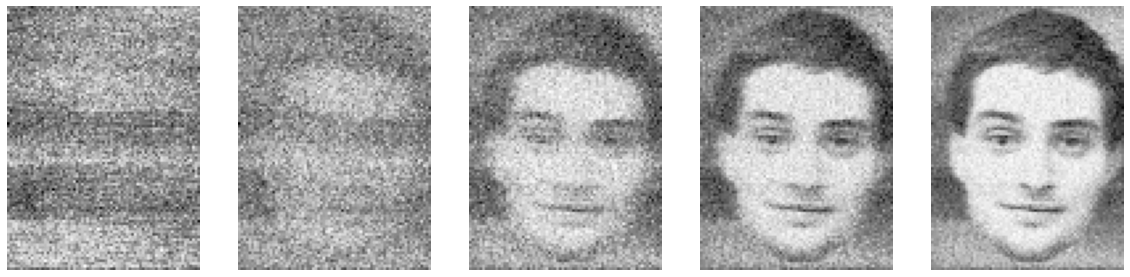

In [ ]:
F = np.random.randint(0, 255, (H, w))
B = np.random.randint(0, 255, (H, W))
a = np.ones(W - w + 1)
a /= np.sum(a)
s = np.random.rand()*pow(64,2)
lens = [50, 100, 300, 500, 1000]
iters = [5, 1, 1, 1, 1]
plt.figure(figsize=(20, 5))
for i, (l, it) in enumerate(zip(lens, iters)):
    F, B, s, a, _ = run_EM(X[:, :, :l], w, F, B, s, a, max_iter=it)
    show(F, i+1, 5)